# By:
#      Dan Ben Ami 316333079
#      Tom Kessous 206018749

# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [64]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [65]:
load_from_drive = True

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/Colab Notebooks/YearPredictionMSD.txt' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Mounted at /content/gdrive


Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [66]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [67]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [68]:
df.head(20)


,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [69]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy().reshape((len(df_test)))

#  It would be problematic to have some songs from an artist in the training set,
#  and other songs from the same artist in the test set, because there is a high
#  probability that different songs of the same artist will be in the same century,
#  and with the same featurs, thus it will be "easy" for the model to predict the
#  label for those songs (because it already saw similar songs during the training).


### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [70]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [71]:
# The test set is used to check accuracy of our model, later on we 
# will use this model to predict released years of other songs and we will not have
# the mean and the std of the songs that not come from the data so we want the test to represent 
# the model's accuracy in real life and that's why we "pretending" to have only the mean and std of the training set.


### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [72]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex].reshape((len(train_ts)))

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# If we use the test set many times it sort of become a part of our training data because 
# we use it to optimize our model in some way. therefore, we want to use the test
#  set only for testing the model performance after the training proccess ends, 
# so we are taking the validation data from the training set and not from the test set. 


## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [73]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y) - (1 - t) * np.log(1 - y)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [74]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  z = X @ w + b
  y = sigmoid(z)
  # here is a treshold for the computatuin so that if some value is close to 0 or 1 
  # in less then the treshold then the min or max value is the treshold or 1 minus the treshold
  treshold = 10**(-12)              
  threshold_y = np.array([np.array(np.where(v <= treshold, treshold, v)) for v in y]).reshape(len(y))
  threshold_y = np.array([np.array(np.where(v >= 1 - treshold, 1 - treshold, v)) for v in threshold_y]).reshape(len(y))
  return threshold_y


### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [75]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # here is our our computation (also described downwards in the textbox)
  # dLdy = -t/y+(1-t)/(1-y)  #SIZE N
  # dydz = y*(1-y)            #SIZE N
  # dzdw = X                #SIZE N*90
  # dzdb = 1                #SIZE N
  # #return (dLdy*dydz).T@dzdw , dLdy*dydz*dzdb
  N = np.shape(X)[0]
  return (X.T)@(y-t)/N , np.mean(y-t)


# **Explenation on Gradients**




By chain rule:
$$\frac{dL}{dw} =\frac{dL}{dy}\cdot\frac{dy}{dz}\cdot\frac{dz}{dw}$$	

$\frac{dL}{dy} =\frac{-t}{y}+\frac{1-t}{1-y}$

$\frac{dy}{dz} =y\cdot(1-y)$

$\frac{dz}{dw} =X$

$$\frac{dL}{db} =\frac{dL}{dy}\cdot\frac{dy}{dz}\cdot\frac{dz}{db}$$	

$\frac{dz}{db} =1$



**Add here an explaination on how the gradients are computed**:

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)



### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [76]:
h = 0.0001
w = np.random.uniform(low=0.1, high=0.2, size=(90,))
b = np.random.uniform(low=0.3, high=0.9, size=(train_xs.shape[0],))
X = train_norm_xs
t = train_ts
y = pred(w, b, X)
y_tag = pred(w, b+h, X)

approx_der = (cost(y_tag,t)-cost(y,t))/h
algo_der = derivative_cost(X,y,t)[1]
print("The analytical results is -", approx_der)
print("The algorithm results is - ", algo_der)
print("diff",approx_der-algo_der)


# '''
# r1 = ...
# r2 = ...
# print("The analytical results is -", r1)
# print("The algorithm results is - ", r2)
# '''


The analytical results is - 0.0033091784046312966
The algorithm results is -  0.0033101743918398747
diff -9.959872085780683e-07


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [84]:
# # Your code goes here. You might find this below code helpful: but it's
# # up to you to figure out how/why, and how to modify the code
h = 0.00001
X = np.random.rand(5,3)
w = np.random.rand(3,)
b = 0.5
t = np.array([1,0,0,1,0])
h_vec =np.zeros(3)
approx_der = np.zeros(3)
y = pred(w, b, X)
for i in range(3):
  h_vec[i] = h
  print(np.shape(w+h_vec),np.shape(X))
  y_tag = pred(w+h_vec, b, X)
  approx_der[i] = (cost(y_tag,t)-cost(y,t))/h
  h_vec[i] = 0

algo_der = derivative_cost(X,y,t)[0]

print("The analytical results is -", approx_der)
print("The algorithm results is - ", algo_der)
print("diff",approx_der-algo_der)


# h_vec = np.zeros(90)
# approx_der = np.zeros(90)
# for i in range(90):
#   h_vec[i] = h
#   y_tag = pred(w+h, b, X)
#   approx_der[i] = (cost(y_tag,t)-cost(y,t))/h
#   h_vec[i] = 0

# algo_der = derivative_cost(X,y,t)[0]
# print("The analytical results is -", approx_der)
# print("The algorithm results is - ", algo_der)
# '''
# r1 = ...
# r2 = ...
# print("The analytical results is -", r1)
# print("The algorithm results is - ", r2)
# '''

(3,) (5, 3)
(3,) (5, 3)
(3,) (5, 3)
The analytical results is - [0.28722737 0.33406045 0.29493992]
The algorithm results is -  [0.28722714 0.33406021 0.29493961]
diff [2.30356229e-07 2.39322456e-07 3.08958667e-07]


### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
def run_gradient_descent(w0, b0,train_norm_xs,train_ts, mu=0.01, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0.copy()
  b = b0
  iter = 0
  Loss = []

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_xs))
    train_norm_xs = train_norm_xs[reindex]
    train_ts = train_ts[reindex].reshape((len(train_ts)))

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs[i:(i + batch_size)]
      t = train_ts[i:(i + batch_size)]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y = pred(w,b,X)

      # update w and b
      updates =  derivative_cost(X, y, t)
      w -= mu*updates[0]
      b -= mu*updates[1]

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 15 == 0 or iter==1):
        y = pred(w,b,val_norm_xs)
        val_cost = cost(y, val_ts)
        val_acc = get_accuracy(y, val_ts)
        print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (
                iter, val_acc * 100, val_cost))
        if(iter != 1):
          Loss+=[val_cost]
          
      if iter >= max_iters:
        break

      # Think what parameters you should return for further use
      
  return w,b,Loss



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

cuurent mu is: 0.1
Iter 1. [Val Acc 50%, Loss 2.923624]
Iter 15. [Val Acc 52%, Loss 2.634540]
Iter 30. [Val Acc 53%, Loss 2.374291]
Iter 45. [Val Acc 54%, Loss 2.161548]
Iter 60. [Val Acc 55%, Loss 1.943424]
Iter 75. [Val Acc 56%, Loss 1.762172]
Iter 90. [Val Acc 57%, Loss 1.614573]
Iter 105. [Val Acc 58%, Loss 1.483515]
Iter 120. [Val Acc 59%, Loss 1.372629]
Iter 135. [Val Acc 60%, Loss 1.268253]
Iter 150. [Val Acc 60%, Loss 1.187108]
cuurent mu is: 0.5
Iter 1. [Val Acc 51%, Loss 2.782195]
Iter 15. [Val Acc 56%, Loss 1.854330]
Iter 30. [Val Acc 59%, Loss 1.254170]
Iter 45. [Val Acc 64%, Loss 0.960969]
Iter 60. [Val Acc 66%, Loss 0.840634]
Iter 75. [Val Acc 68%, Loss 0.742583]
Iter 90. [Val Acc 69%, Loss 0.695920]
Iter 105. [Val Acc 70%, Loss 0.651275]
Iter 120. [Val Acc 70%, Loss 0.630460]
Iter 135. [Val Acc 71%, Loss 0.610936]
Iter 150. [Val Acc 71%, Loss 0.609543]
cuurent mu is: 1
Iter 1. [Val Acc 51%, Loss 2.717732]
Iter 15. [Val Acc 61%, Loss 1.226179]
Iter 30. [Val Acc 65%, Loss 

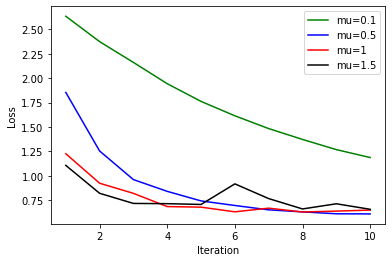

In [80]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

Loss=np.zeros([4,10])
x_axis = np.linspace(1, 10, num=10,endpoint=True)
itr=0
for mu in [0.1,0.5,1,1.5]:
  print("cuurent mu is:",mu)
  Loss[itr] = run_gradient_descent(w0,b0,train_norm_xs,train_ts,mu,100,150)[2]
  itr+=1
plt.plot(x_axis,Loss[0],color='green',label="mu=0.1")
plt.plot(x_axis,Loss[1],color='blue',label="mu=0.5")
plt.plot(x_axis,Loss[2],color='red',label="mu=1")
plt.plot(x_axis,Loss[3],color='black',label="mu=1.5")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Explain and discuss your results here:**


We made several expriments that show that the mu and batch size are strongly correlated. We can see from the plot that for mu=



```
# This is formatted as code
```



### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

cuurent mu,batch size are: 0.5 50
Iter 1. [Val Acc 46%, Loss 2.949471]
Iter 15. [Val Acc 52%, Loss 1.784633]
Iter 30. [Val Acc 55%, Loss 1.309518]
Iter 45. [Val Acc 57%, Loss 1.082156]
Iter 60. [Val Acc 62%, Loss 0.913326]
Iter 75. [Val Acc 63%, Loss 0.844457]
Iter 90. [Val Acc 64%, Loss 0.760469]
Iter 105. [Val Acc 65%, Loss 0.725727]
Iter 120. [Val Acc 67%, Loss 0.700529]
Iter 135. [Val Acc 67%, Loss 0.709177]
Iter 150. [Val Acc 69%, Loss 0.660122]
cuurent mu,batch size are: 0.5 100
Iter 1. [Val Acc 45%, Loss 2.955304]
Iter 15. [Val Acc 53%, Loss 1.707310]
Iter 30. [Val Acc 56%, Loss 1.237754]
Iter 45. [Val Acc 59%, Loss 0.989792]
Iter 60. [Val Acc 62%, Loss 0.841987]
Iter 75. [Val Acc 64%, Loss 0.753661]
Iter 90. [Val Acc 66%, Loss 0.693314]
Iter 105. [Val Acc 67%, Loss 0.659985]
Iter 120. [Val Acc 69%, Loss 0.628846]
Iter 135. [Val Acc 70%, Loss 0.630887]
Iter 150. [Val Acc 69%, Loss 0.624403]
cuurent mu,batch size are: 0.5 150
Iter 1. [Val Acc 45%, Loss 2.946215]
Iter 15. [Val Acc

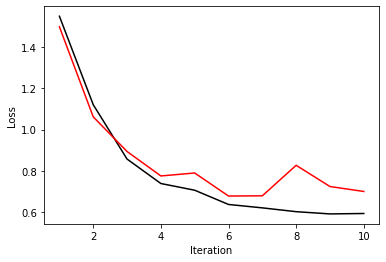

In [81]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

x_axis = np.linspace(1, 10, num=10,endpoint=True)

min_loss = [99]*10
max_loss = [0]*10

for mu in np.linspace(0.5,0.8,3):
  for batch_size in [50,100,150]:
    print("cuurent mu,batch size are:",mu, batch_size)
    w,b,Loss = run_gradient_descent(w0,b0,train_norm_xs,train_ts,mu,batch_size,150)
    if Loss[9]<min_loss[9]:
      min_loss =  Loss
      # min_idx = [mu,batch_size]
      w_opt = w
      b_opt = b
    if Loss[9]>max_loss[9]:
      max_loss = Loss
      # max_idx = [mu,batch_size]


plt.plot(x_axis,min_loss,color='black')
plt.plot(x_axis,max_loss,color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


**Explain and discuss your results here:**




We saw from the previus part that for mu=0.01 we got the best results (minimum loss), so in this part we perform fine tunning for the mu and batch size to see which of the combination gives us the best results (minimum Loss).

### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [82]:
# Write your code here
train_acc = get_accuracy(pred(w_opt,b_opt,train_norm_xs),train_ts)
val_acc = get_accuracy(pred(w_opt,b_opt,val_norm_xs),val_ts)
test_acc = get_accuracy(pred(w_opt,b_opt,test_norm_xs),test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


train_acc =  0.7152218314540203  val_acc =  0.7158  test_acc =  0.7058493124152625


**Explain and discuss your results here:**


We get around 70% accuracy with all part of the data (train,val,test) so we can understand that there is no overfitting during the training proccess.

### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [83]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression( multi_class='multinomial').fit(train_norm_xs,train_ts)

train_acc = get_accuracy(model.predict(train_norm_xs),train_ts)
val_acc = get_accuracy(model.predict(val_norm_xs),val_ts)
test_acc = get_accuracy(model.predict(test_norm_xs),test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

train_acc =  0.7326952128880992  val_acc =  0.73456  test_acc =  0.7267286461359674


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
